In [2]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
import pandas as pd

data_1 = pd.read_csv("/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/business_data.csv")
data_2 = pd.read_csv("/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/education_data.csv")
data_3 = pd.read_csv("/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/entertainment_data.csv")
data_4 = pd.read_csv("/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/sports_data.csv")
data_5 = pd.read_csv("/kaggle/input/news-articles-classification-dataset-for-nlp-and-ml/technology_data.csv")


data = pd.concat([data_1, data_2, data_3, data_4, data_5], ignore_index=True)

data = data.drop(["headlines", "description", "url"], axis="columns")
data


,content,category
0,"Sitharaman, the first full-time woman finance ...",business
1,The merger of Tata group’s budget airlines Air...,business
2,The Air India group plans to induct one aircra...,business
3,Indian exporters have asked the central govern...,business
4,The Air India group plans to induct one aircra...,business
...,...,...
9995,"Vivaldi, the free browser founded by Opera co-...",technology
9996,"Meta has concluded its Connect 2023 event, unv...",technology
9997,Samsung has been launching its Galaxy S series...,technology
9998,"“When things don’t go as planned, we return to...",technology


In [4]:
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
import torchtext

class MyDataset(Dataset):
    def __init__(self, X, y, max_len=200):
        self.X = X
        self.y = y
        self.max_len = max_len
        
        self.label_encoder = LabelEncoder().fit(y)
        self.vocab = torchtext.vocab.GloVe(name='6B', dim=50)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        label = self.label_encoder.transform([self.y.iloc[idx]])
        label = torch.tensor(label)
        
        text = self.X.iloc[idx]
        tokens = text.split()
        
        if len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]
        else:
            diff = self.max_len - len(tokens)
            
            tokens += ['<pad>'] * diff
        
        X = self.vocab.get_vecs_by_tokens(tokens, lower_case_backup=True)
        
        return X, label[0]
    
    
dataset = MyDataset(data['content'], data['category'])
            

.vector_cache/glove.6B.zip: 862MB [02:40, 5.36MB/s]                               
100%|█████████▉| 399999/400000 [00:15<00:00, 25252.41it/s]


In [20]:
dataset[5999]

(tensor([[-0.6617,  1.0200, -0.1776,  ..., -1.0892, -0.3224,  1.3101],
         [ 0.3419,  0.2617, -0.0797,  ..., -0.8694, -0.2686, -0.0338],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]),
 tensor(2))

In [6]:
from torch.utils.data import random_split

train_ratio = 0.8

train_data, test_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [7]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [8]:
from torch import nn
import torch.nn.functional as F
import numpy as np
import math

from torch import Tensor


class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TextClassifier(nn.Module):
    def __init__(self, encoding_dim, max_len, num_classes):
        super().__init__()
        
        self.pos_encoder = PositionalEncoding(d_model=encoding_dim, max_len=max_len)

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=encoding_dim, nhead=2, batch_first=True, dim_feedforward=64),
            num_layers=1
        )

        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(encoding_dim*max_len, num_classes)

    def forward(self, x):
        out = self.pos_encoder(x)
        out = self.encoder(out)
        out = self.flatten(out)
        out = self.linear1(out)
        return out


    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)

        return y_pred.cpu().numpy()


model = TextClassifier(encoding_dim=50, max_len=200, num_classes=5).to(device)
model

TextClassifier(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
        )
        (linear1): Linear(in_features=50, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=50, bias=True)
        (norm1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=10000, out_features=5, bias=True)
)

In [9]:
params_num = 0

for param in model.parameters():
    size = param.size()
    
    num = 1
    for item in size:
        num *= item
    params_num += num

params_num

66919

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [11]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)


        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, test_loader,
                epochs=10,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=TextClassifier, opt=AdamW(lr=0.010000), epochs=10, device=cuda

Epoch    1   11sec	loss:       3.76	val_loss:      0.553	accuracy_score:      0.791	val_accuracy_score:      0.873	
Epoch    2   10sec	loss:      0.212	val_loss:      0.243	accuracy_score:      0.938	val_accuracy_score:      0.927	
Epoch    3   11sec	loss:     0.0969	val_loss:      0.229	accuracy_score:      0.971	val_accuracy_score:      0.941	
Epoch    4   11sec	loss:     0.0919	val_loss:      0.178	accuracy_score:       0.97	val_accuracy_score:      0.948	
Epoch    5   11sec	loss:     0.0762	val_loss:      0.436	accuracy_score:      0.971	val_accuracy_score:       0.91	
Epoch    6   10sec	loss:     0.0741	val_loss:      0.273	accuracy_score:      0.977	val_accuracy_score:      0.941	
Epoch    7   10sec	loss:     0.0878	val_loss:      0.363	accuracy_score:      0.971	val_accuracy_score:      0.917	
Epoch    8   10sec	loss:     0.0869	val_loss:      0.211	accuracy_score:      0.972	val_accuracy_score

[]

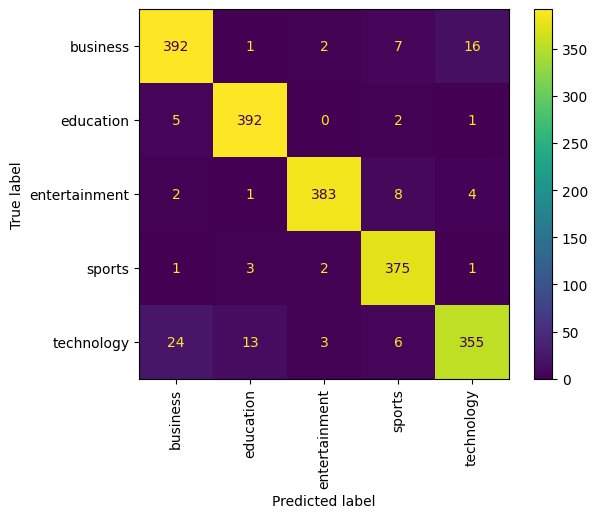

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = model.to('cpu')  
loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))
X_test, y_test = next(iter(loader))

y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.argmax(-1), display_labels=dataset.label_encoder.classes_)
plt.xticks(rotation=90)
plt.plot()

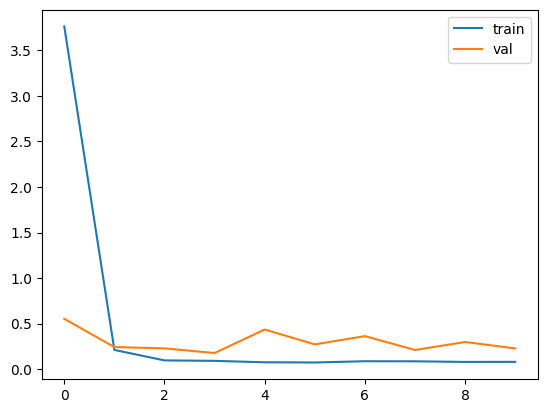

In [14]:
plt.plot(history["loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.legend()
plt.show()